# Compring Transfer rates bewteen SLAC and NERSC using a pair of dedicated and public machines

The memory to memory transfers rates between two nodes, one at SLAC and the second at NERSC were measured. The test were performed between
two public data transfer nodes (dtn) and two dedicated dtns. In the case of the dedicated nodes only the test transfers were running. 

The dedicated and public machines used the same TCP configuration but the dedicated node at NERSC (dtn05) didn't have flow control 
enabled where as the public machines limited each TCP flow to 10Gb/s. Some references about control flow are:

* [packet-pacing](https://fasterdata.es.net/network-tuning/packet-pacing/) (presentation: [pacing-results.pdf](https://fasterdata.es.net/assets/fasterdata/FQ-pacing-results.pdf)).


## Transfer tests

The public transfer nodes were psexport01 (psexport03) at SLAC and dtn03 at NERSC. The dedicated nodes were psexport01 and dtn05. 
Transfer tests ran every 2 hours and for each test five transfers, each 3 minutes long, using different parallel transfer streams:

    1, 2, 4, 8, 16 streams


In [1]:
import os
import json
import jmespath
import importlib
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import promquery as pq
pjoin = os.path.join

In [2]:
plt.rcParams['font.size'] = '20'
plt.rcParams['lines.markersize'] = '120'
outfld = "/cds/home/w/wilko/projects/transfers/lastmile/results"
day = datetime.now().strftime("%Y%m%d")
toGiB = pow(2, 30)

In [3]:
# Load one-to-one transfer for public nodes 
res = json.load(open("/cds/home/w/wilko/projects/transfers/lastmile/logs/repeat_v1/one_r2_4.json"))

data = jmespath.search("[*].[rate, reverse, nsrc, streams, ndest, start, stop]", res)
df = pd.DataFrame(data, columns=("rate", "reverse", "nsrc", "streams", "ndest","start", "stop"))
df['date'] = pd.to_datetime(df.start, unit='s')
df.rate*= (8 * pow(2,30) / 1E9)
df['ncl'] = df.streams * df.ndest
df_pub = df.copy()

# Load dedicated
res = json.load(open("/cds/home/w/wilko/projects/transfers/lastmile/logs/repeat_v1/one_r5.json"))

data = jmespath.search("[*].[rate, reverse, nsrc, streams, ndest, start, stop]", res)
df = pd.DataFrame(data, columns=("rate", "reverse", "nsrc", "streams", "ndest","start", "stop"))
df['date'] = pd.to_datetime(df.start, unit='s')
df.rate*= (8 * pow(2,30) / 1E9)
df['ncl'] = df.streams * df.ndest
df_det = df.copy()
df_det.streams += 0.2

print("Entries dedicated:", len(df_det), "public", len(df_pub))

Entries dedicated: 520 public 1211


# Mean and standard variantion 

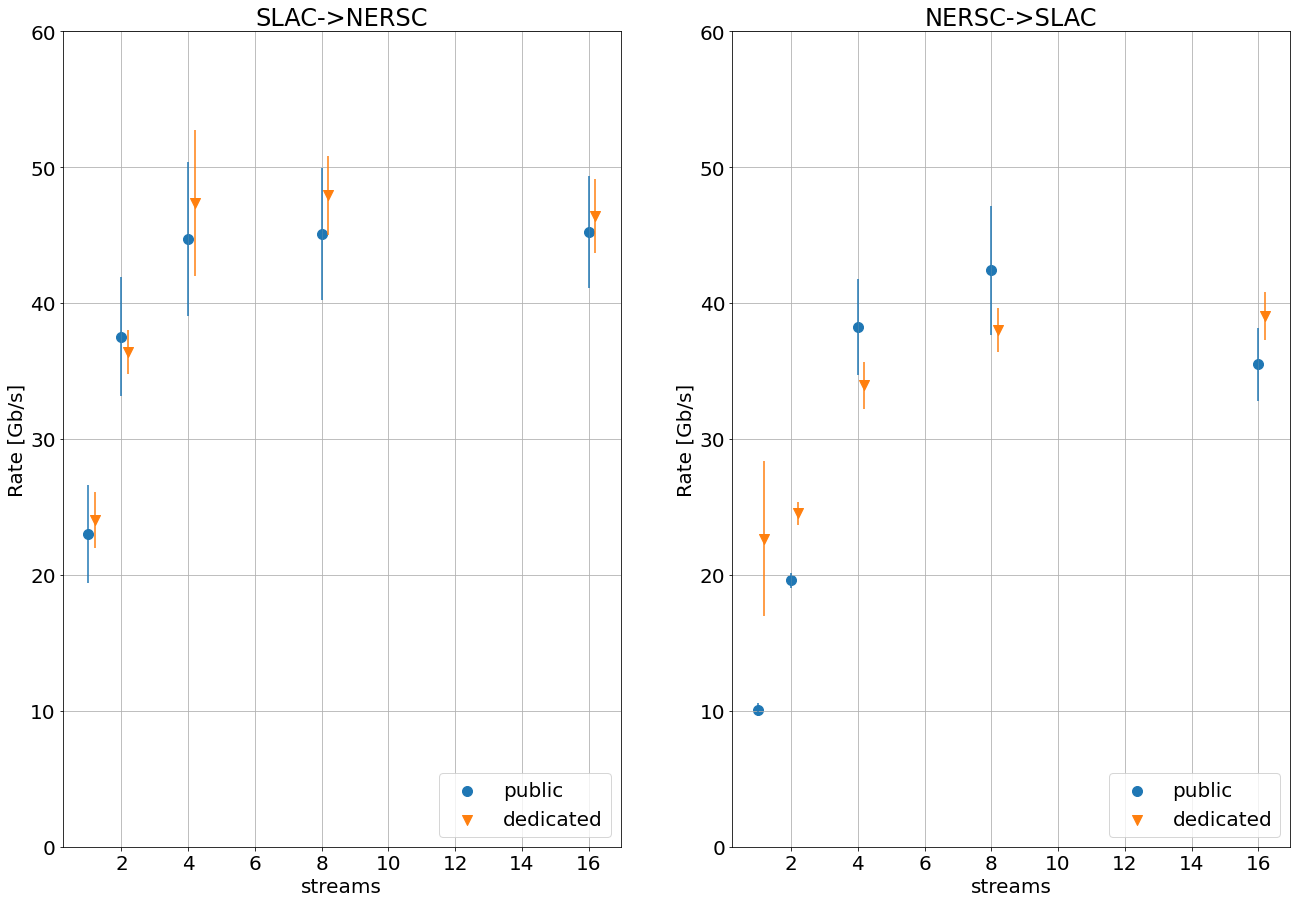

In [4]:
# Plot mean and variation for One-to-One transfers  vs. #streams
fig, axis = plt.subplots(1,2, sharex=True)

stats_pub = df_pub.groupby(["streams","reverse"]).rate.agg(['mean','std'])
stats_pub.iloc[ stats_pub.index.get_level_values('reverse') == 0 ]

stats_det = df_det.groupby(["streams","reverse"]).rate.agg(['mean','std'])
stats_det.iloc[ stats_det.index.get_level_values('reverse') == 0 ]

#fig, ax = plt.subplots(1)
fig.set_size_inches(22,15)

ax = axis[0]
stats_pub[ stats_pub.index.get_level_values('reverse') == 0 ].reset_index().plot.scatter( x='streams', y='mean', color="tab:blue", ax=ax, s=100, yerr='std', label="public")
stats_det[ stats_det.index.get_level_values('reverse') == 0 ].reset_index().plot.scatter( x='streams', y='mean', color="tab:orange", ax=ax, s=100, yerr='std', label="dedicated", marker='v')

ax = axis[1]
stats_pub[ stats_pub.index.get_level_values('reverse') == 1 ].reset_index().plot.scatter( x='streams', y='mean', color="tab:blue", ax=ax, s=100, yerr='std', label="public")
stats_det[ stats_det.index.get_level_values('reverse') == 1 ].reset_index().plot.scatter( x='streams', y='mean', color="tab:orange", ax=ax, s=100, yerr='std', label="dedicated", marker='v')

for i, title in enumerate(("SLAC->NERSC", "NERSC->SLAC")): 
    ax = axis[i]
    ax.grid()
    ax.set_ylim((0,60))
    ax.set_title(title)
    ax.set_xlabel("streams")
    ax.set_ylabel("Rate [Gb/s]")
    ax.legend(loc=4)

# Rate distributions fomr one-to-one transfers

Text(0.5, 1.0, 'deticated machines')

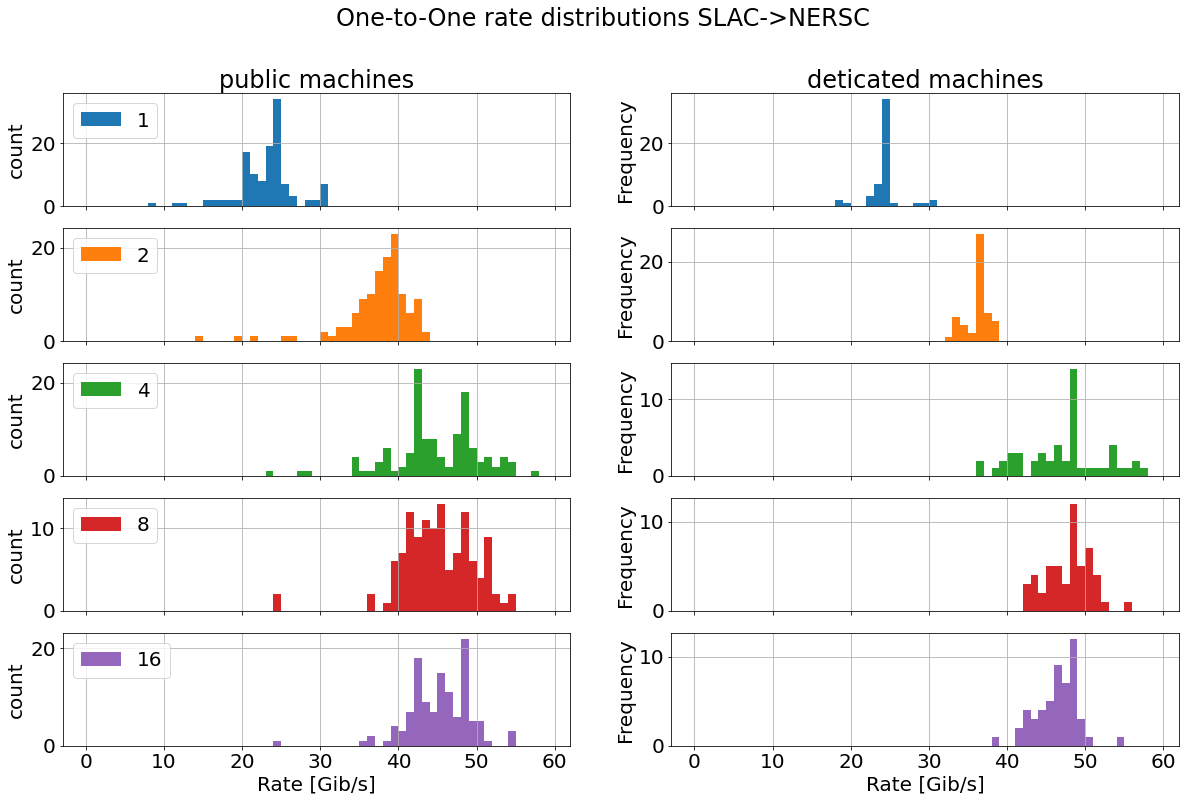

In [5]:
# Plot the rate distribution for different streams

fig, axis = plt.subplots(5,2, sharex=True)
ax = axis[0][0]
fig.set_size_inches(20,12)
fig.suptitle("One-to-One rate distributions SLAC->NERSC")

colors = ("tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple") 
for n, streams in enumerate((1, 2, 4, 8, 16)):
    ax = axis[n][0]
    df_pub[ (df_pub.reverse == 0) & (df_pub.streams == streams) ].rate.plot.hist(bins=list(range(0,60,1)), ax=ax, grid=True, color=colors[n], label=streams, legend=True)
    ax.set_ylabel("count")
    ax.legend(loc=2)
    
    ax = axis[n][1]
    df_det[ (df_det.reverse == 0) & (df_det.streams == streams + 0.2) ].rate.plot.hist(bins=list(range(0,60,1)), ax=ax, grid=True, color=colors[n])
    
axis[-1][0].set_xlabel("Rate [Gib/s]")
axis[0][0].set_title("public machines")

axis[-1][1].set_xlabel("Rate [Gib/s]")
axis[0][1].set_title("deticated machines")
    

Text(0.5, 0, 'Rate [Gib/s]')

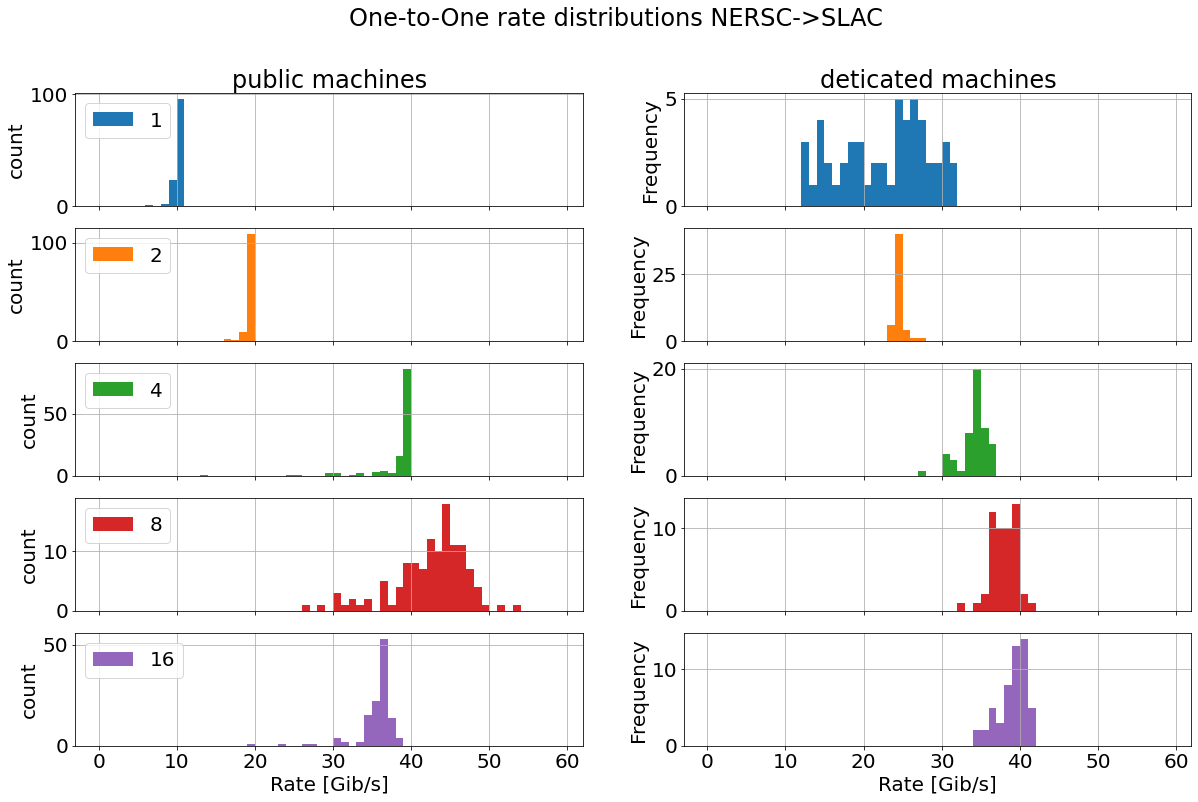

In [6]:
# Plot the rate distribution for different streams

fig, axis = plt.subplots(5,2, sharex=True)
ax = axis[0][0]
fig.set_size_inches(20,12)
fig.suptitle("One-to-One rate distributions NERSC->SLAC")

colors = ("tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple") 
for n, streams in enumerate((1, 2, 4, 8, 16)):
    ax = axis[n][0]
    df_pub[ (df_pub.reverse == 1) & (df_pub.streams == streams) ].rate.plot.hist(bins=list(range(0,60,1)), ax=ax, grid=True, color=colors[n], label=streams, legend=True)
    ax.set_ylabel("count")
    ax.legend(loc=2)
    
    ax = axis[n][1]
    df_det[ (df_det.reverse == 1) & (df_det.streams == streams + 0.2) ].rate.plot.hist(bins=list(range(0,60,1)), ax=ax, grid=True, color=colors[n])
    
axis[-1][0].set_xlabel("Rate [Gib/s]")
axis[0][0].set_title("public machines")

axis[0][1].set_title("deticated machines")
axis[-1][1].set_xlabel("Rate [Gib/s]")
    